# PacMan

## Restrições para análise do projeto

- Não são permitidos movimentos na **diagonal**, apenas, **cima**, **baixo**, **esquerda** e **direita**.
- Pacman não passa mais de uma vez pela mesma célula (busca deve levar em conta posições exploradas).
- O objetivo do problema é sempre o mesmo: apenas chegar na posição objetivo.
- As soluções são qualificadas por custo, onde para cada movimento que o pacman fazer há um custo associado a posição destino, podendo assumir 3 valores diferentes: custo se a posição não conter nada, custo se houver moeda ou custo se hover moeda grande - tudo definido no construtor da classe *Maze*.
- A não ser que seja especificado, os 3 diferentes custos são:
    - Espaço livre: 10
    - Coin: 2
    - Grande Coin: 1


## Observações sobre a implementação 

- Mapas são registrados em um arquivo *.txt* e deve formatado corretamente com o mesmo número de caracteres em cada linha, apenas um pacman - posicao inicial **(P)** e pelo menos um objetivo **(X)**.
- Estado definido por tupla **(x, y)** - posição no mapa.

### Importações de bibliotecas

In [1]:
%matplotlib inline
import time
from enum import Enum
from aima.search import *
from aima.utils import *
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import random
import pandas as pd
from IPython.display import Markdown, display

In [2]:
def plot_image(*images, titles = [], table_format=(1, 0), figsize=(15, 15), axis=False, fontsize=20):
    '''
    Função auxiliar para comparar diferentes soluções (por imagens)
    '''
    max_lines = table_format[0] if table_format[0]!=0 else len(images)
    max_columns = table_format[1] if table_format[1]!=0 else len(images)

    fig = plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        ax = fig.add_subplot(max_lines, max_columns, i+1)
        
        if len(titles)==len(images):
            ax.set_xlabel(titles[i], fontsize=fontsize)
        
        if axis is False:
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.xaxis.set_ticks_position('none') 
            ax.yaxis.set_ticks_position('none') 
        if isinstance(image, str):
            ax.axis('off')
            ax.text(0, 0.5, image, horizontalalignment='left', fontsize=fontsize+4,
                    verticalalignment='center', transform=ax.transAxes)
        else:
            ax.imshow(image)
    plt.show()

### Gerenciador do labirinto

In [3]:
class PosType(Enum):
    '''
    Enumerado com caracteres possiveis para representação do labirinto
    '''
    FREE = (' ', (0, 0, 0, 0))
    COIN = ('.', 'coin.png')
    B_COIN = ('o', 'b_coin.png')
    WALL = ('|', (0, 0, 204, 255))
    GHOST = ('G', 'ghost.png')
    PACMAN = ('P', 'pacman.png')
    GOAL = ('X', (0, 255, 0, 255))
    PATH = ('+', (52, 180, 235, 255))
    
    def __new__(cls, *args, **kwds):
        obj = object.__new__(cls)
        obj._value_ = args[0]
        return obj

    def __init__(self, char, sprite):
        self.char = char
        if isinstance(sprite, str):
            black = np.full((14, 14, 4), (0, 0, 0, 0), dtype=np.uint8)
            background = Image.fromarray(black)
            foreground = Image.open(os.path.join('sprites', sprite))
            background.paste(foreground, (0, 0), foreground)
            self.sprite = np.asarray(background)
        else:
            self.sprite = np.full((14, 14, 4), sprite)
    
    @staticmethod
    def valid_inits():
        '''
        Retorna todos os enumerados validos que podem estar contidos em arquivo txt
        '''
        return [ptype for ptype in PosType if ptype not in [PosType.PATH]]

    @staticmethod
    def valid_pacman_positions():
        '''
        Retorna os enumerados onde o pacman pode se movimentar
        '''
        return [PosType.FREE, PosType.COIN, PosType.B_COIN, PosType.GOAL, PosType.PACMAN]

In [4]:
class Maze:
    '''
    Classe para ler arquivos txt representativos dos labirintos e comportamento dos elementos ao interagir
    com o pacman

    :self.w: largura do mapa
    :self.h: altura do mapa
    :self.initial_state: estado inicial (x, y)
    :self.goal_states: lista de estados objetivos [(x, y)]
    :self.free_cost: custo de uma célula livre
    :self.coin_cost: custo moeda simples
    :self.bcoin_cost: custo de uma moeda grande
    '''

    def __init__(self, filepath, free_cost=10, coin_cost=2, bcoin_cost=1):
        # Classe construtora para um maze - ler arquivo e guarda em uma lista de strings
        # Faz algumas checagens para prevenir formatos errados
        file = open(filepath, "r")
        self._maze = file.read().splitlines()
        file.close()
        self.w = len(self._maze[0])
        self.h = len(self._maze)
        self.initial_state = None
        self.goal_states = []
        self.free_cost = free_cost
        self.coin_cost = coin_cost
        self.bcoin_cost = bcoin_cost

        for y in range(self.h):
            if len(self._maze[y]) is not self.w:
                raise ValueError('Invalid map dimensions')
            else:
                # Percorre linhas obtidas pelo arquivo procurando por seugestao de posicao inicial do
                # pacman e os objetivos (se houverem), há uma simples checagem de formato invalido de mapa
                for x in range(self.w):
                    pos = (x, y)
                    if self.get(pos) is PosType.PACMAN:
                        if self.initial_state is None:
                            self.initial_state = pos
                        else:
                            raise ValueError('Multiple pacmans position')
                    elif self.get(pos) is PosType.GOAL:
                        self.goal_states.append(pos)
                    elif self.get(pos) not in PosType.valid_inits():
                        raise ValueError('Invalid char {}'.format(self._maze[y][x]))

                # Remove objetivos e pacman do mapa
                self._maze[y] = self._maze[y].replace(PosType.PACMAN.value, ' ').replace(PosType.GOAL.value, ' ')

    def get(self, pos):
        # definimos _maze[y][x]
        return PosType(self._maze[pos[1]][pos[0]])

    def get_cost(self, pos):
        # retorna o custo de acordo com a posicao
        ptype = self.get(pos)
        if ptype == PosType.COIN:
            return self.coin_cost
        elif ptype == PosType.B_COIN:
            return self.bcoin_cost
        else:
            return self.free_cost

    def possible_positions(self, pos):
        '''
        Retorna possiveis posicoes que o pacman consegue chegar a partir de pos
        :pos: posição do pacman (x, y)
        return lista de posicoes (x, y)
        '''
        x, y = pos[0], pos[1]
        possible_positions = []
        for step in [(0, -1), (1, 0), (0, 1), (-1, 0)]:  # up, right, down, left
            # soma os steps com x, e y, tomando cuidados com os limites transversais do mapa
            newX = self.w - 1 if x + step[0] < 0 else (x + step[0]) % self.w
            newY = self.h - 1 if y + step[1] < 0 else (y + step[1]) % self.h
            pos = (newX, newY)
            if self.get(pos) in PosType.valid_pacman_positions():
                possible_positions.append(pos)

        return possible_positions

    def __str__(self):
        string = ''
        for line in self._maze:
            string = string + line + '\n'
        return string

    @staticmethod
    def _print(maze):
        for line in maze:
            print(''.join(line))
        print('\n')
        
    @staticmethod
    def _put_initial_and_goals(maze_list, initial_state, goal_states):
        maze_list[initial_state[1]][initial_state[0]] = PosType.PACMAN.value
        for goal in goal_states:
            maze_list[goal[1]][goal[0]] = PosType.GOAL.value
        return maze_list

    @staticmethod
    def _put_solution(maze_list, solution):
        for state in solution:
            maze_list[state[1]][state[0]] = PosType.PATH.value
        return maze_list
    
    def _copy_maze_list(self):
        maze = list()
        for line in self._maze:
            maze.append(list(line))
            
        return maze
    
    def _get_solution(self, solution):
        maze = self._copy_maze_list()
        Maze._put_solution(maze, solution)
        Maze._put_initial_and_goals(maze, self.initial_state, self.goal_states)
        return maze
    
    def _get_map(self):
        maze = self._copy_maze_list()
        Maze._put_initial_and_goals(maze, self.initial_state, self.goal_states)
        return maze
    
    def print_solution(self, solution):
        '''
        Printa solucao
        :solution: lista de posicoes que levam a solucao [(x, y) ...]
        '''
        Maze._print(self._get_solution(solution))

    def print_map(self):
        '''
        Printa mapa com posicao inical e objetivo
        '''
        Maze._print(maze._get_map())
        
    def _get_map_image(self):
        maze = self._get_map()
        image = np.zeros((14*self.h, 14*self.w, 4), dtype=np.uint8)
        for x in range(self.w): 
            for y in range(self.h):
                image[y*14:(y+1)*14, x*14:(x+1)*14] = PosType(maze[y][x]).sprite
        return image
    
    def get_map_image(self):
        return self._get_map_image()[:,:,:3]
    
    def get_solution_image(self, solution):
        solution.append(self.initial_state)
        foreground = Image.fromarray(self._get_map_image())
        
        background = np.full((14*self.h, 14*self.w, 4), (0, 0, 0, 255), dtype=np.uint8)
        for (x, y) in solution:
            background[y*14:(y+1)*14, x*14:(x+1)*14] = PosType.PATH.sprite
        background = Image.fromarray(background)
        background.paste(foreground, (0, 0), foreground)
        image = np.asarray(background)
        return image[:,:,:3]
        
    def plot_map(self):
        plot_image(self.get_map_image())
        
    def plot_solution(self, solution):
        plot_image(self.get_solution_image(solution))

### Definição da classe problema

In [5]:
from aima.search import Problem

class MazePacmanProblem(Problem):
    '''
    Define o conjunto de ações, resultados, custo, e teste objetivo para o problema
    '''

    def __init__(self, maze):
        '''
        Instancia um objeto problema
        :initial: estado inicial do pacman - posicao por uma tupla (x, y)
        :goal: estado final, obejtivo do pacman - posição por uma tupla (x, y) ou lista de tuplas
        '''
        Problem.__init__(self, maze.initial_state, maze.goal_states)
        self.maze = maze

    def actions(self, state):
        return self.maze.possible_positions(state)

    def result(self, state, action):
        return action

    def goal_test(self, state):
        if isinstance(self.goal, list):
            return state in self.goal
        else:
            return state == self.goal

    def path_cost(self, cost_so_far, stateA, action, stateB):
        # custo do caminho é incrementado com o custo da proxima célula
        return cost_so_far + self.maze.get_cost(action)
    
    def value(self, state):
        [xGoal, yGoal] = self.goal[0]
        [xState, yState] = state

        value = abs(xGoal - xState) + abs(yGoal - yState)

        return value

### Classe, funções auxiliares

In [6]:
class Statistics:
    '''
    Classe para auxiliar/organizar as metragens de estatisticas dos algoritmos
    :self.iterations: numero de iteracoes
    :self.expanded: numero de nos expandidos pelo algoritmo
    :self.memory: pico de memoria (numero maximo de estados salvos ao mesmo tempo)
    :self.time: tempo em ms
    :self.path_cost: custo total da solução
    '''

    def __init__(self, iterations=0, expanded=1, memory=1, distance=None):
        self.iterations = iterations
        self.expanded = expanded
        self.memory = memory
        self.time = None
        self.path_cost = None
        self.distance = None
        self._start_time = time.time()

    def update_iterations(self, increment):
        self.iterations = self.iterations + increment

    def update_expanded(self, increment):
        self.expanded = self.expanded + increment

    def update_memory(self, new_memory):
        if new_memory > self.memory:
            self.memory = new_memory

    def finish(self, path_cost):
        '''
        Finaliza o timer (aberto no construtor) e salva custo da solucao
        '''
        self.path_cost = path_cost
        self.time = time.time() - self._start_time
        
    def items(self):
        dict_items = self.__dict__.copy()
        del dict_items['_start_time']
        return dict_items

    def __str__(self):
        string = ''
        string = string + "Distancia para solução: {}\n".format(self.distance)
        string = string + "Número de iterações: {}\n".format(self.iterations)
        string = string + "Número de nós expandidos: {}\n".format(self.expanded)
        string = string + "Estados salvos (memória máxima): {}\n".format(self.memory)
        string = string + "Tempo real: {}s\n".format(self.time)
        string = string + "Custo da solução: {}".format(self.path_cost)

        return string

In [7]:
def manhattan_distance(pos, maze):
    '''
    Distancia  manhattan considerando regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = min(abs(goal[0]-pos[0]), abs(goal[0]-(pos[0]+maze.w)), abs(goal[0]-(pos[0]-maze.w)))
        y_distance = min(abs(goal[1]-pos[1]), abs(goal[1]-(pos[1]+maze.h)), abs(goal[1]-(pos[1]-maze.h)))
        distances.append(x_distance+y_distance)
        
    return min(distances)

In [8]:
def random_analysis(maze, n_analysis, solver_function):
    '''
    Sorteia 'n_analysis' posicoes válidas do mapa 'maze' e resolve com a solver_function
    :solver_function: lista com o primeiro elemento com ponteiro para a função para resolver o problema 
    e os proximos os parametros (excluindo o 'problem')
    '''
    statistics_list = []
    i = 0
    while i < n_analysis:    
        random_goal = (random.randrange(0, maze.w), random.randrange(0, maze.h))
        # verifica se a posicao gerada pode ser considerada objetivo
        if (maze.get(random_goal) in [PosType.FREE, PosType.COIN, PosType.B_COIN, PosType.GOAL]):
            maze.goal_states = [random_goal] 
            distance = manhattan_distance(maze.initial_state, maze)
            problem = MazePacmanProblem(maze)
            statistics, node = solver_function[0](problem, *solver_function[1:])
            statistics.distance = distance 
            #maze.plot_solution(node.solution())
            statistics_list.append(statistics.items())
            i = i + 1
            
    return pd.DataFrame(statistics_list)

In [27]:
def analysis_mazes(mazes_list, solver_function_list, figsize=None, mazeargs=[]):
    '''
    Função para facilitar comparações visuais de soluções entre diferentes mapas e algoritmos
    :solver_function_list: lista de solver_functions, onde cada elemento é também uma lista com primeiro elemento
    do tipo ponteiro para a função, segundo o nome do método utilizado para gerar texto e legendas, e o restante
    os parametros opcionais que essa função pode necessitar desconsiderando a instancia do problema
    '''
    # Heuristica para um bom tamanho da figura a ser exibida
    if figsize==None:
        figsize = (20, 18*len(solver_function_list))
        
    for maze_name in mazes_list:
        maze = Maze(os.path.join('mazes', maze_name), *mazeargs)
        map_image = maze.get_map_image()
        images = []
        titles = []
        for i, solver_function in enumerate(solver_function_list):
            problem = MazePacmanProblem(maze)
            statistics, node = solver_function[0](problem, *solver_function[2:])
            statistics.distance = manhattan_distance(maze.initial_state, maze)
            solution_image = maze.get_solution_image(node.solution())
            statistics_text = '{}\n\n{}'.format(solver_function[1], statistics)
            images.extend([solution_image, statistics_text])
            titles.extend(["Figura {}: Solução do labirinto {} utilizando {}".format(
                i+1, maze_name, solver_function[1]), ''])
        display(Markdown('### {}'.format(maze_name)))
        plot_image(*images, titles=titles, table_format=(0, 2), figsize=figsize, fontsize=15)
        print('\n\n')

# Labirintos utilizados nos testes

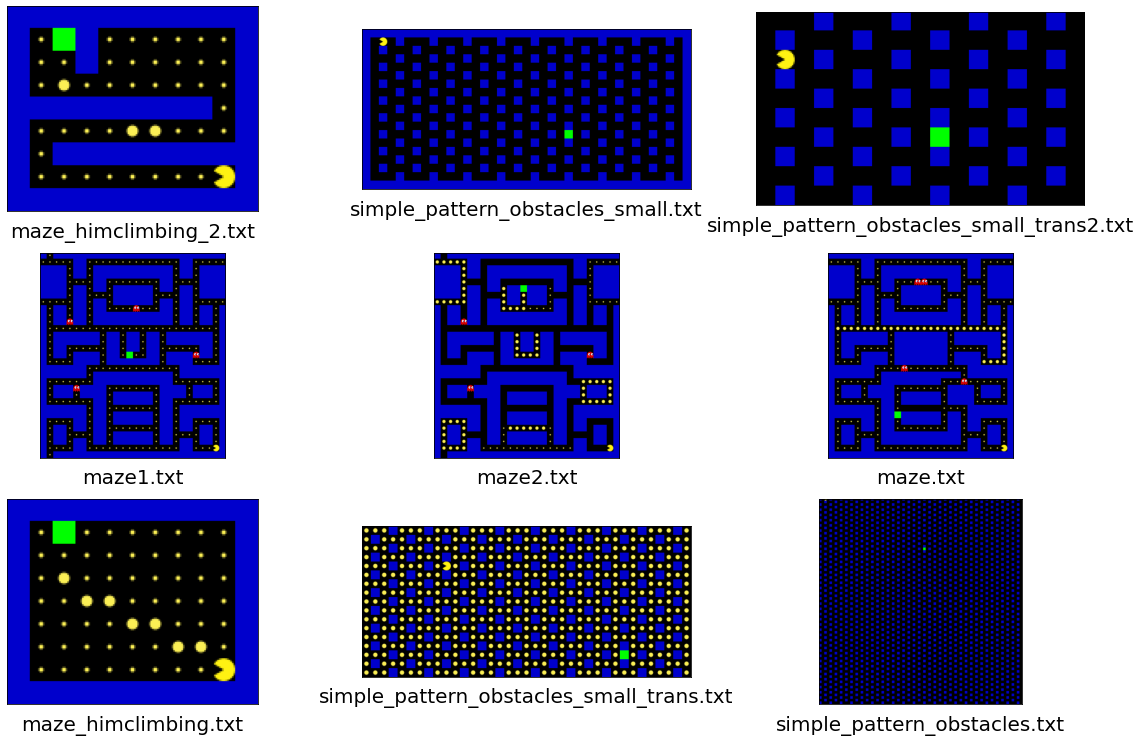

In [15]:
images = []
titles = []
for maze_name in os.listdir('mazes'):
    maze = Maze(os.path.join('mazes', maze_name))
    images.append(maze.get_map_image())
    titles.append(maze_name)
    
plot_image(*images, titles=titles, table_format=(0,3), figsize=(20, 40))

# BFS e DFS

In [24]:
def depth_first_search(problem):
    statistics = Statistics()

    frontier = [(Node(problem.initial))]

    explored = set()
    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.pop()
        if problem.goal_test(node.state):
            statistics.finish(node.path_cost)
            return statistics, node
        explored.add(node.state)
        childs = [child for child in node.expand(problem)
                  if child.state not in explored and child not in frontier]
        frontier.extend(childs)
        statistics.update_expanded(len(childs))

    statistics.finish(node.path_cost)
    return statistics, None


def breadth_first_search(problem):
    statistics = Statistics()
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    statistics.finish(node.path_cost)
                    return statistics, child
                frontier.append(child)
                statistics.update_expanded(1)
    statistics.finish(node.path_cost)
    return statistics, None

### maze1.txt

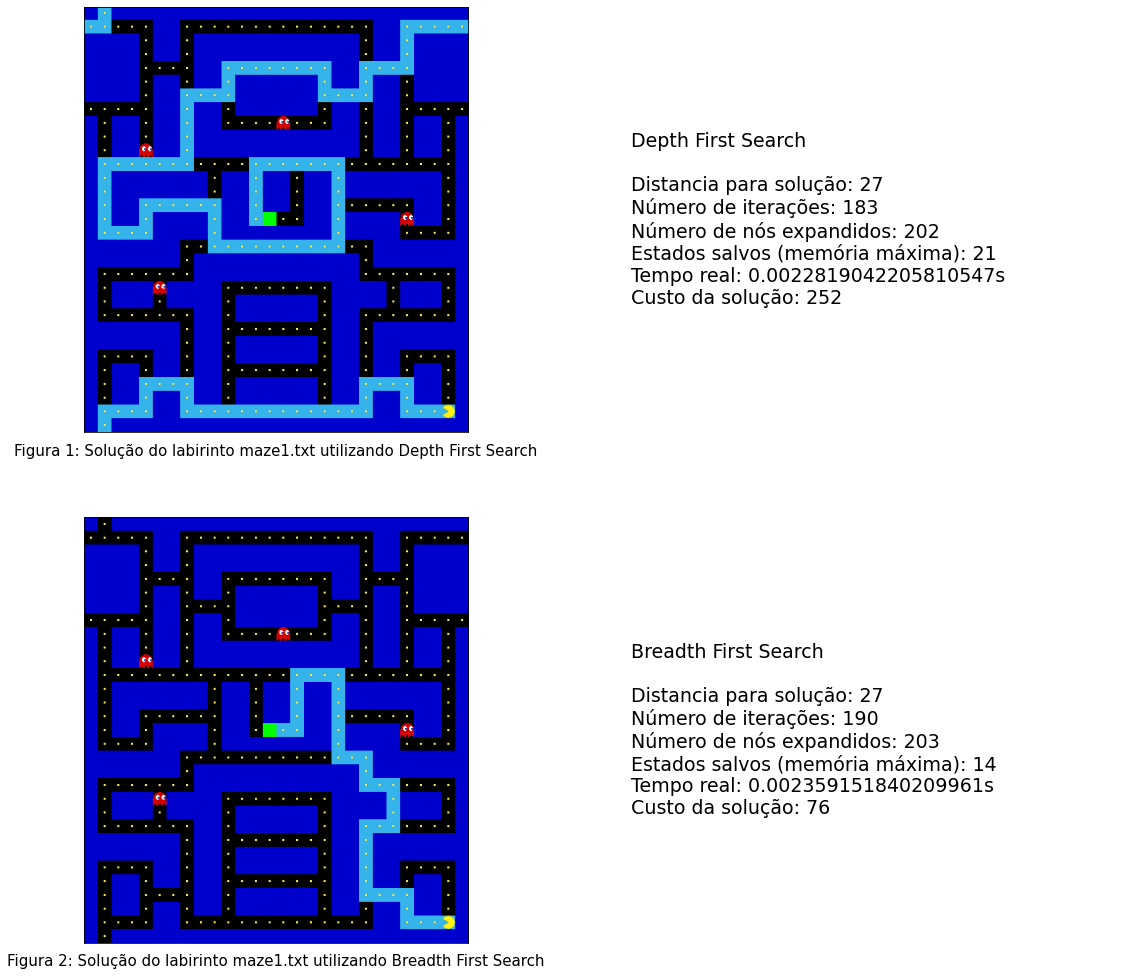

In [28]:
analysis_mazes(['maze1.txt'], 
               [[depth_first_search, 'Depth First Search'], [breadth_first_search, 'Breadth First Search']])

Neste exemplo do **maze1.txt** observa-se como ambos algoritmos, *Depth First Search* e *Breadth First Search* conseguem encontrar uma solução devido às suas propriedades de **completude**, entretanto ao contrário do **DFS**, o **BFS** para esse labirinto em específico encontrou uma **solução ótima** com custo 76, bem discrepante em relação ao **DFS** que encontrou caminho com custo 252. 

Como o **DFS** expande os nós na ordem cima, direita, baixo, esquerda, para colocar na pilha, há uma prioridade do caminho escolhido priorizar os movimentos esquerda, baixo, direita e cima, nessa ordem, isso explica o caminho escolhido pelo algoritmo neste exemplo.

Observa-se também que tanto o **BFS** como o **DFS** tiveram coincidemente quase o mesmo número de iterações. Quanto ao consumo de memória, notamos que o **BFS** consumiu menos memória do que o **DFS** - o que não foi um caso isolado desse exemplo mas é explicado devido a própria natureza do problema: cada estado na média tem poucos filhos  possíveis (no máximo 4), e como consideramos que o PACMAN não pode passar pela mesma posição, o espaço de busca reduz drasticamente visto que há muitas instersecções dos possíveis caminhos no labirinto, o que faz com o que o **BFS** descarte nós da pilha rapidamente enquanto o **DFS** como ele tende a "ir mais fundo", ele acaba tendo que empilhar vários estados ao longo desse caminho "mais longo" que ele acaba encontrando, por isso o consumo de memória ficou maior nesse algoritmo em relação ao **BFS**. 

Vale ressaltar que o **BFS** nesse exemplo é **ótimo**, pois **qualquer movimento do pacman tem o mesmo custo** -  todo mapa esta preenchido por *coin*, o qual atribuímos custo 2. Na pŕoxima célula teremos um exemplo onde o **BFS não é ótimo**.

### maze2.txt

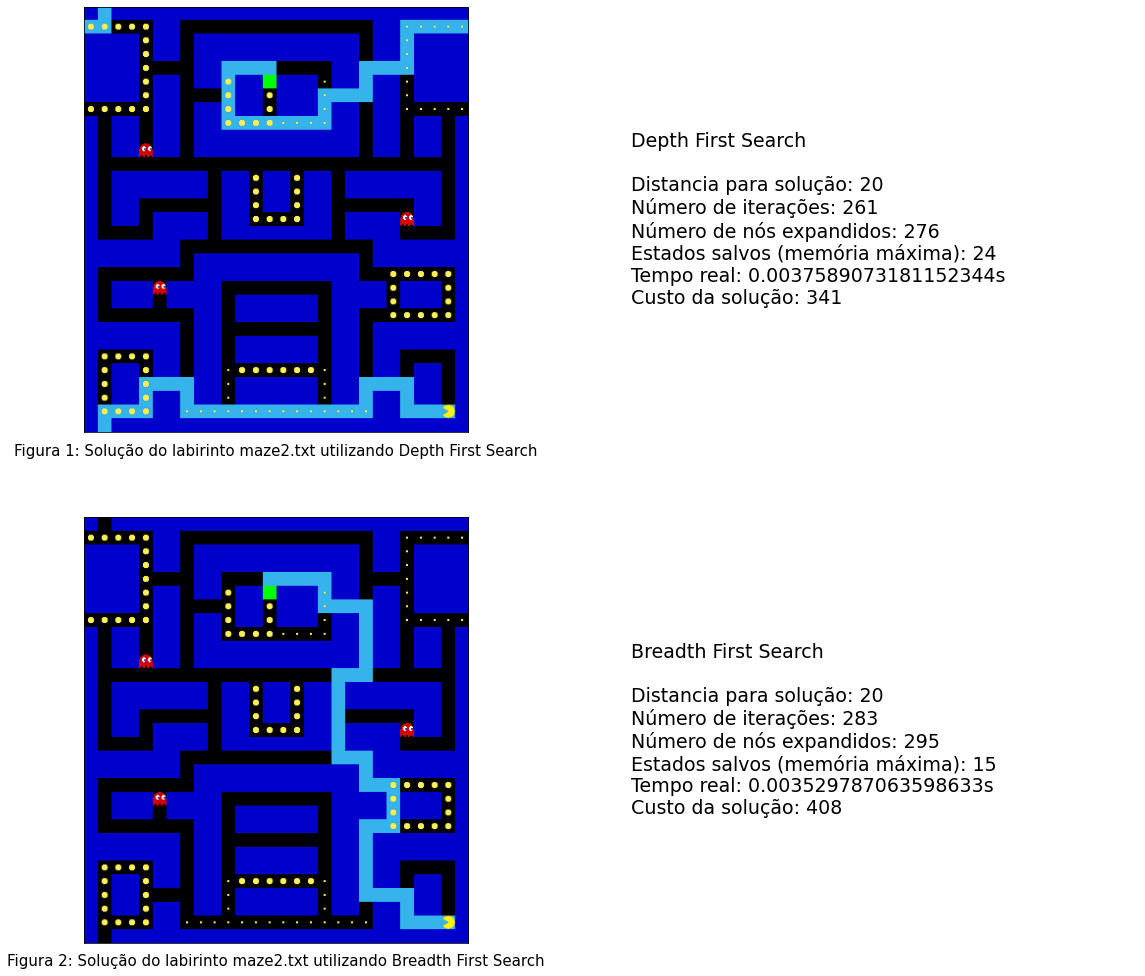

In [29]:
analysis_mazes(['maze2.txt'], 
               [[depth_first_search, 'Depth First Search'], [breadth_first_search, 'Breadth First Search']])

Neste exemplo do **maze2.txt**, observamos que o BFS **não encontrou solução ótima** (seria apenas com custo iguais para qualquer transição), pois existe um caminho com menor custo ao encontrado que evita o alto custo de espaço livre (10), inclusive neste exemplo o **DFS**, "por sorte", acabou encontrando um caminho melhor que o **BFS**, apesar de ainda não ser ótimo neste cenário. Caminhos ótimos, em que transições de estado possuem custos diferentes podem ser encontrados utilizando o algoritmo *Uniform Cost Search*.

# Uniform cost search

In [30]:
def _best_first_search(problem, f, display=False):
    statistics = Statistics()
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()

    while frontier:
        statistics.update_memory(len(frontier))
        statistics.update_iterations(1)
        node = frontier.pop()
        if problem.goal_test(node.state):
            statistics.finish(node.path_cost)
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return statistics, node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                statistics.update_expanded(1)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
                    statistics.update_expanded(1)
    statistics.finish(node.path_cost)
    return statistics, None

def uniform_cost_search(problem, display=False):
    return _best_first_search(problem, lambda node: node.path_cost, display)

### maze2.txt

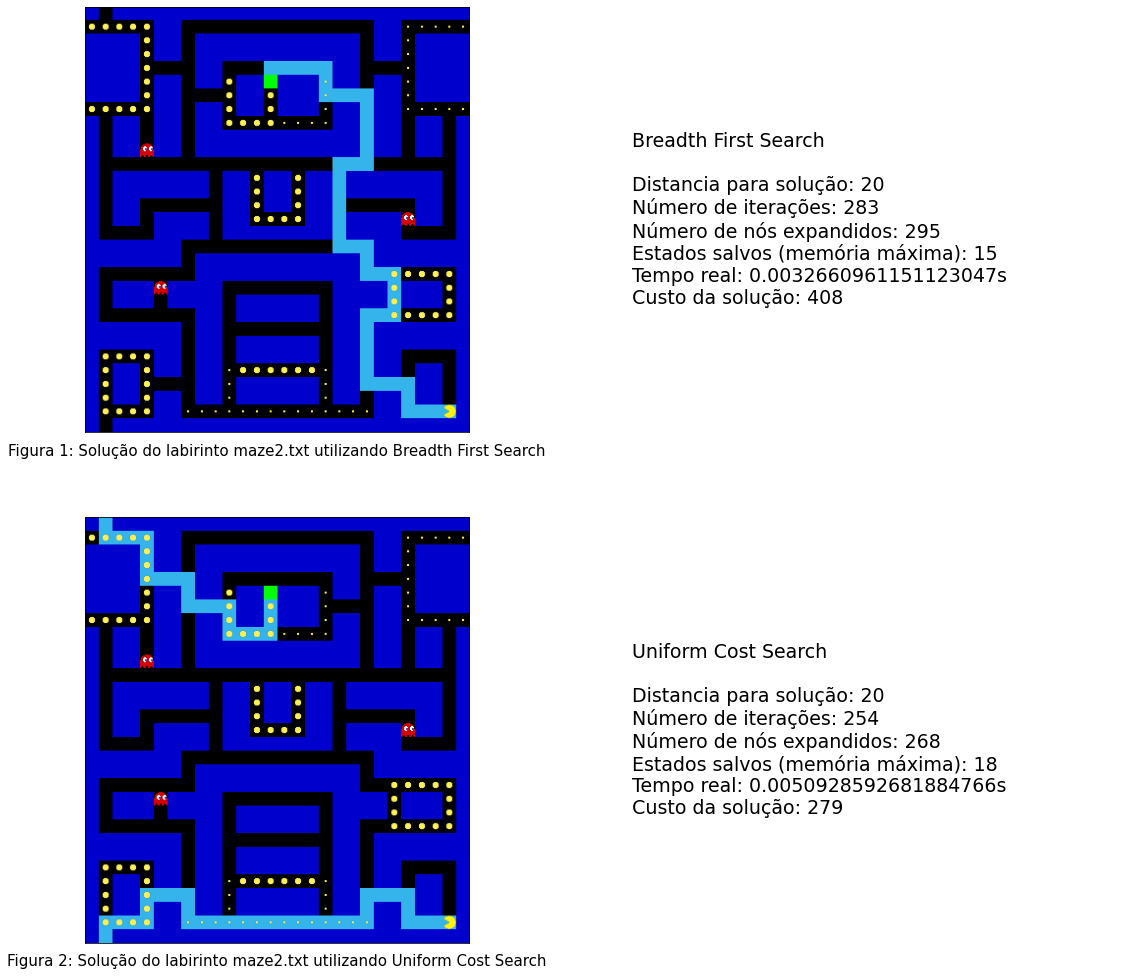

In [34]:
analysis_mazes(['maze2.txt'], 
               [[breadth_first_search, 'Breadth First Search'],
                [uniform_cost_search, 'Uniform Cost Search']])

Observa-se que agora que o *Uniform Cost Search* encontrou uma solução melhor do que o **BFS** para o problema do **maze2.txt** e é ótima com custo 286 e ainda com menos iterações 254 contra 283.

Mas será que conseguiremos reduzir o custo computacional (número de iterações) destes algoritmos indroduzindo heuristicas?

# Heurísticas

In [35]:
def ldistance_trans(pos, maze, l=1):
    '''
    Distancia l (l=1 manhattan, l=2 euclidean) considerando regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = min(abs(goal[0]-pos[0]), abs(goal[0]-(pos[0]+maze.w)), abs(goal[0]-(pos[0]-maze.w)))
        y_distance = min(abs(goal[1]-pos[1]), abs(goal[1]-(pos[1]+maze.h)), abs(goal[1]-(pos[1]-maze.h)))
        distances.append(((x_distance**l)+(y_distance**l))**(1./l))
        
    return min(distances)

def ldistance(pos, maze, l=1):
    '''
    Distancia l (l=1 manhattan, l=2 euclidean) sem considerar regioes transversaveis
    '''
    
    distances = []
    for goal in maze.goal_states:
        x_distance = abs(goal[0]-pos[0])
        y_distance = abs(goal[1]-pos[1])
        distances.append(((x_distance**l)+(y_distance**l))**(1./l))
        
    return min(distances)


def h_manhattan_distance_trans(pos, maze):
    return ldistance_trans(pos, maze, 1)

def h_manhattan_distance(pos, maze):
    return ldistance(pos, maze, 1)

def h_euclidean_distance_trans(pos, maze):
    return ldistance_trans(pos, maze, 2)

def h_euclidean_distance(pos, maze):
    return ldistance(pos, maze, 2)

# Best first search

In [36]:
def best_first_search(problem, heuristic_function, display=False):
    return _best_first_search(problem, lambda node: heuristic_function(node.state, problem.maze), display)

A heuristica mais comum de se pensar para resolver este problema é sempre escolher a posição que me deixa mais próximo para chegar no objetivo, uma vez que quanto mais próximo, menos passos o paman terá que dar para concluir e portanto, menor será o custo total - isso pode ser feito medindo a distância do estado atual para o objetivo. Resolvemos comparar a distância euclidiana e de manhattan aplicados ao algoritmo *Best First Search*.

### maze2.txt

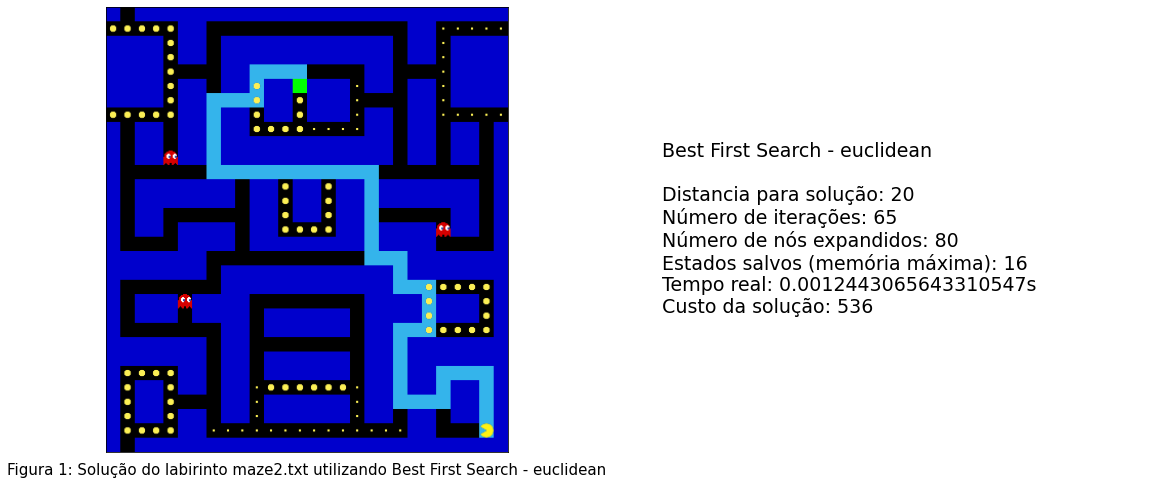

In [38]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - euclidean', h_euclidean_distance]])

Como esperado, o *Best First Search* com a **heurística de distância euclidiana** para o problema **não apresentou solução ótima** como *Uniformed Cost Search*, em contrapartida, este método apresentou consideravelmente um menor de iterações em relação ao aos métodos anteriores. Entretanto, propositalmente, há um erro nessa heuristíca em não considerar que o mapa pode ser transversável (funcionaria melhor para labirintos que não possui essas regiões). Ao corrigir o calculo dessa heuristíca:

### maze2.txt

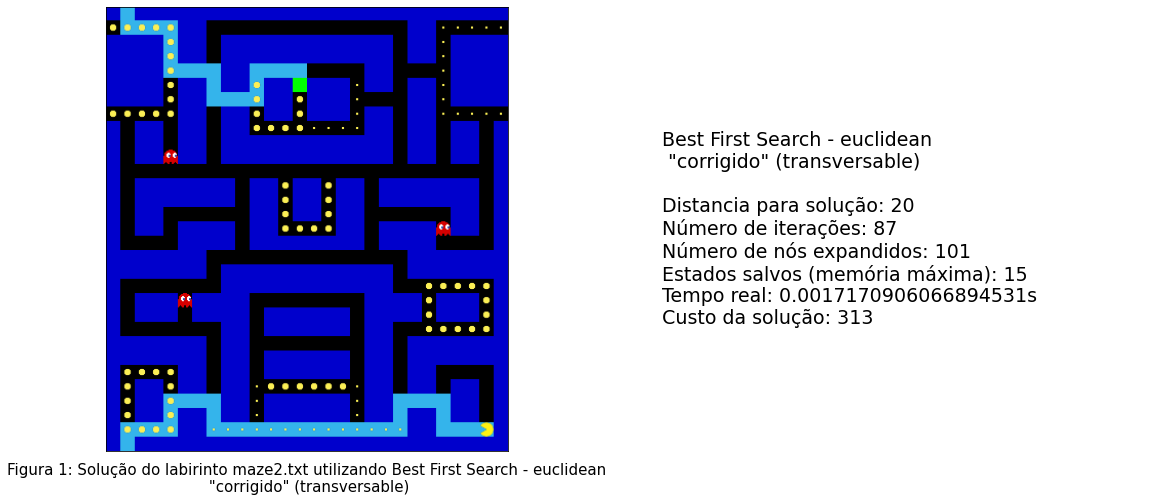

In [39]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - euclidean\n "corrigido" (transversable)', 
                 h_euclidean_distance_trans]])

Observamos que agora com a heuristíca corrigida, o *Best First Search* com a **heurística de distância euclidiana** encontrou uma solução melhor (313), apesar de ainda não ser ótima igual ao *Uniformed Cost Search* (279), porém conforme já observado com menor numero de iterações.

Comparando com distancia de manhattan: 

### maze2.txt

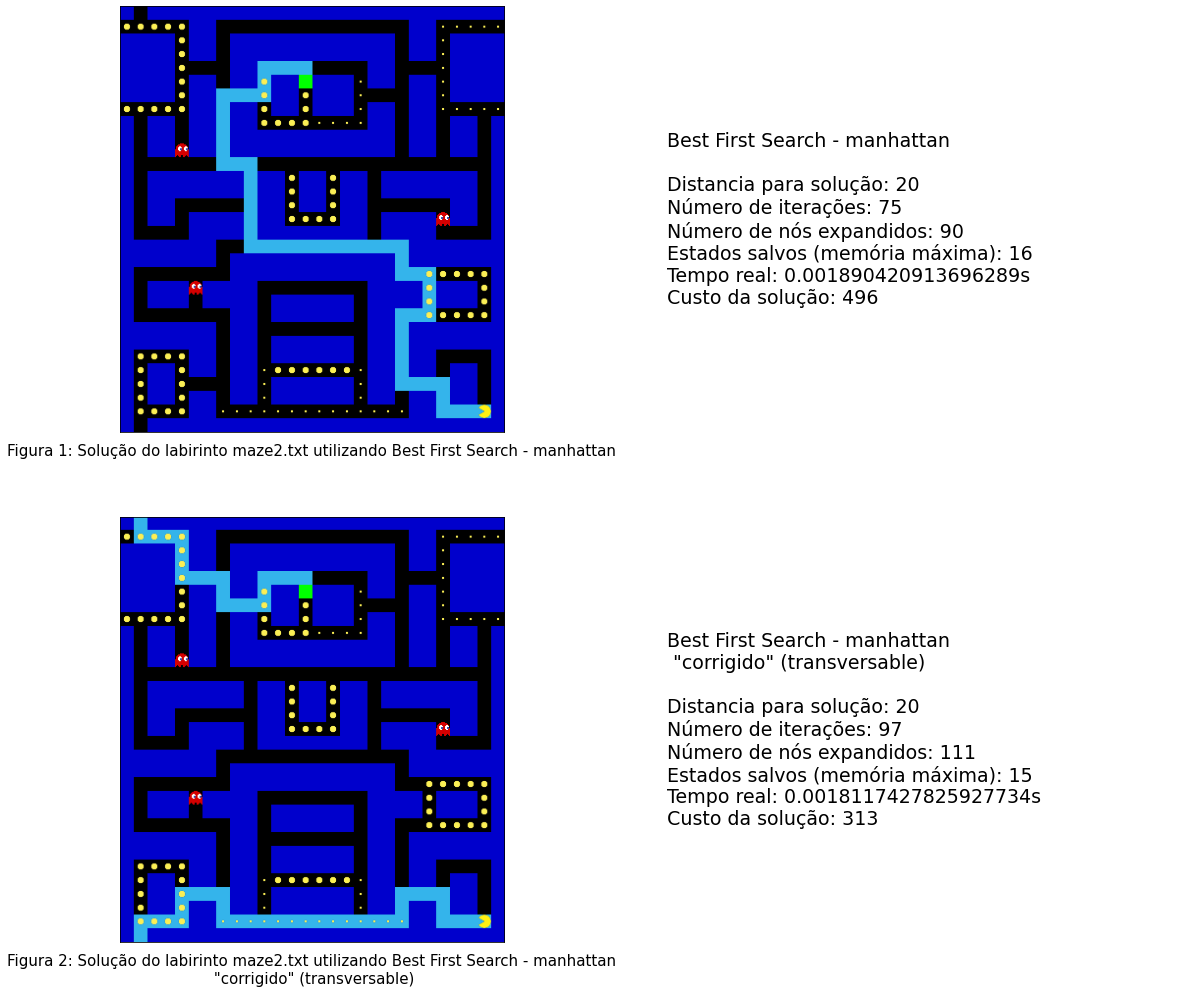

In [40]:
analysis_mazes(['maze2.txt'], 
               [[best_first_search, 'Best First Search - manhattan', h_manhattan_distance],
                [best_first_search, 'Best First Search - manhattan\n "corrigido" (transversable)', h_manhattan_distance_trans]])

Observa-se que a distancia de manhattan levaram as mesmas soluções que a euclidiana. É possível notar levemente um número maior de iterações com a **distância de manhattan**. Apesar desse experimento ser inconclusivo, suspeitavamos que heurística de manhattan levasse à um algoritmo melhor pelo fato do pacman não se mover pelas diagonais - essa heurítica é mais realista em relação ao menor caminho que pode existir a partir de uma posição.

Entretanto, algo que pode ser observado é que a distância euclidiana é boa para "desempate" do melhor caminho que o pacman deve escolher, por exemplo, se o pacman esta na posição **(xp, yp)** e o objetivo estiver na **(xg, yg)**, considerando **xp!=xg** e **yp!=yg** mesmo que o pacman tenha 4 opções de células destino, apenas duas delas aproxima do objetivo terão o mesmo custo de manhattan, o que acontece a maioria dos casos, já a distância euclidiana, nesse cenário, terá o menor custo através do movimento no eixo que estiver mais distante, a não ser que a distancias nos eixos forem iguais, não tendo um desempate.

O resultado é que a distancia de manhattan vai privilegiar a ordem dos movimentos definidos pelo algoritmo (visto que as posições canditatas possuem o mesmo custo), enquanto a distancia euclidiana vai privelegiar células que levam a um caminho mais diagonalizado. Como pode ser visto na execução abaixo:

### simple_pattern_obstacles_small.txt

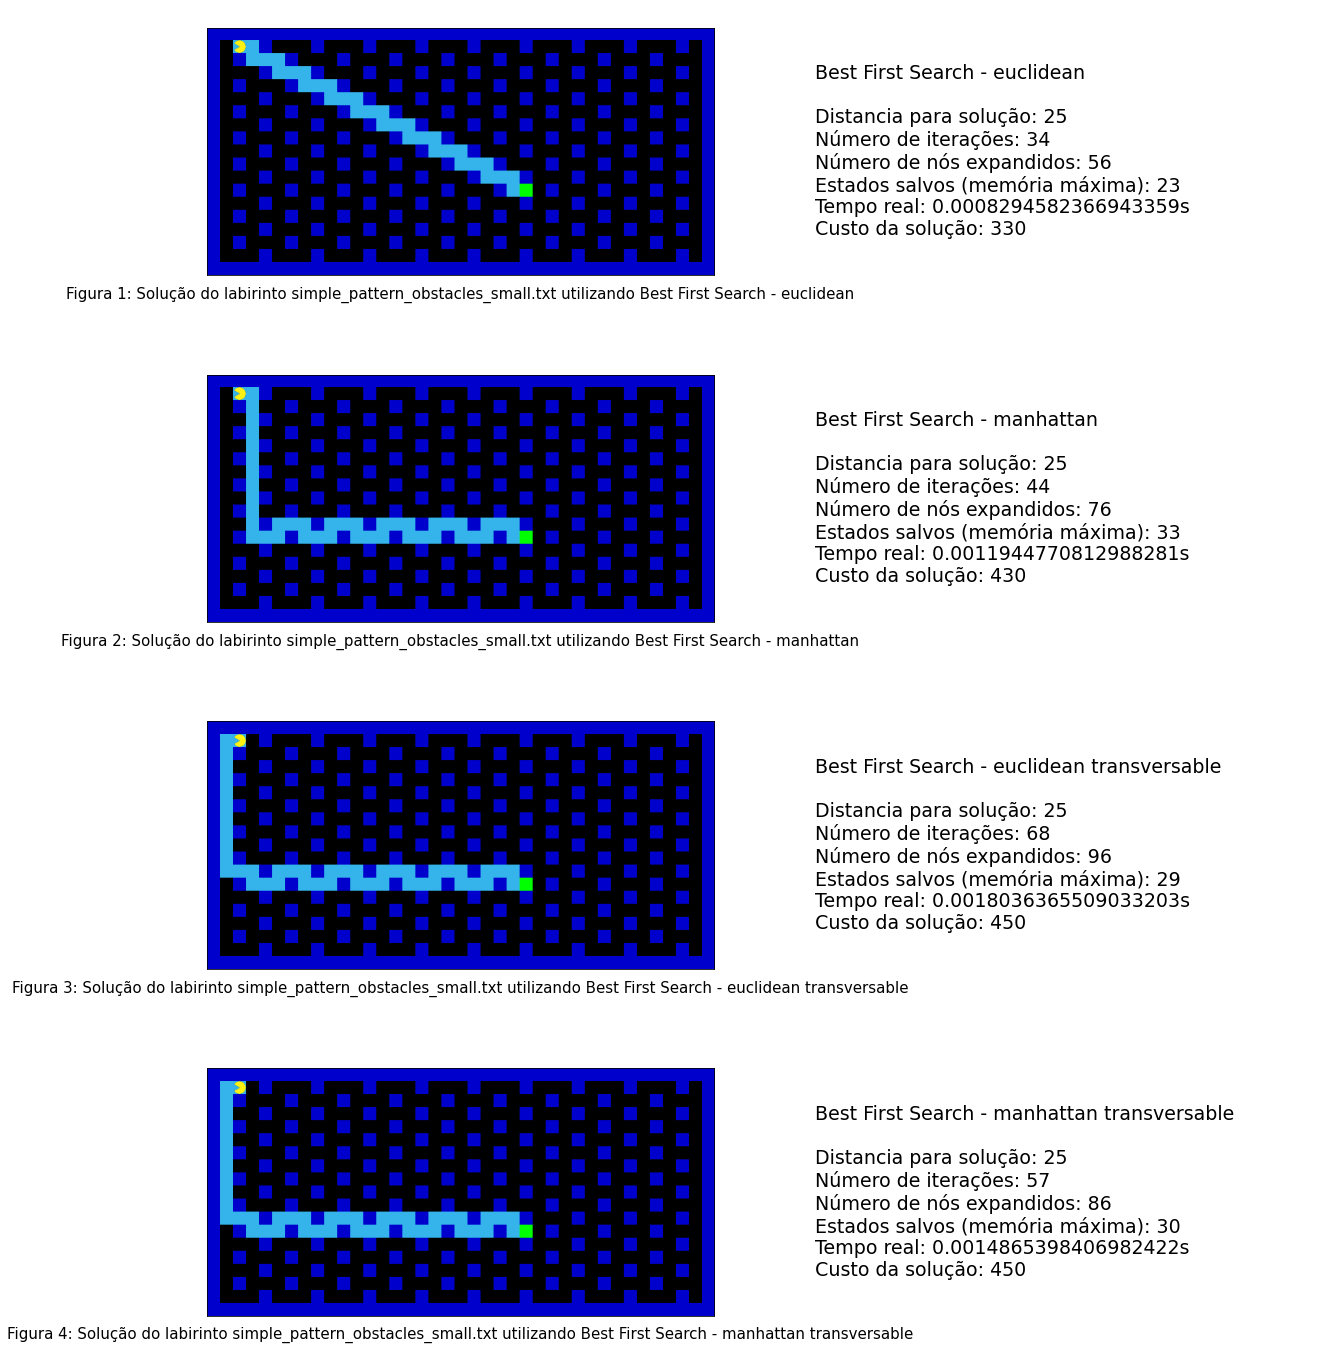

In [41]:
analysis_mazes(['simple_pattern_obstacles_small.txt'], 
               [[best_first_search, 'Best First Search - euclidean', h_euclidean_distance],
                [best_first_search, 'Best First Search - manhattan', h_manhattan_distance],
                [best_first_search, 'Best First Search - euclidean transversable', h_euclidean_distance_trans],
                [best_first_search, 'Best First Search - manhattan transversable', h_manhattan_distance_trans]], 
               figsize=(20, 50))

Esse mapa **simple_pattern_obstacles_small.txt** é interessante para observar o efeito de considerar a heuristíca transversavel ou não. Pode-se notar que como o mapa não é transversavel em nenhuma parte e a distancia do PACMAN para o objetivo seria menor se o pacman pudesse atravessar o mapa para chegar do outro lado, ele tende a escolher posições que leva a travessia do mapa, o que acaba levando a uma solução com custo maior.

Ao utilizar a heuristíca mais adequada podemos ver que a distancia **euclidiana** acabou encontrando uma solução melhor do que a **manhattan**, pelo fator de "desempate" - de sempre aproximar pelo eixo que esta mais longe da solução - o que "por sorte" acabou levando à uma solução melhor que por sinal é ótima também.

# A* search

In [42]:
def astar_search(problem, heuristic_function, display=False):
    return _best_first_search(problem, lambda n: n.path_cost + heuristic_function(n.state, problem.maze))

### maze2.txt

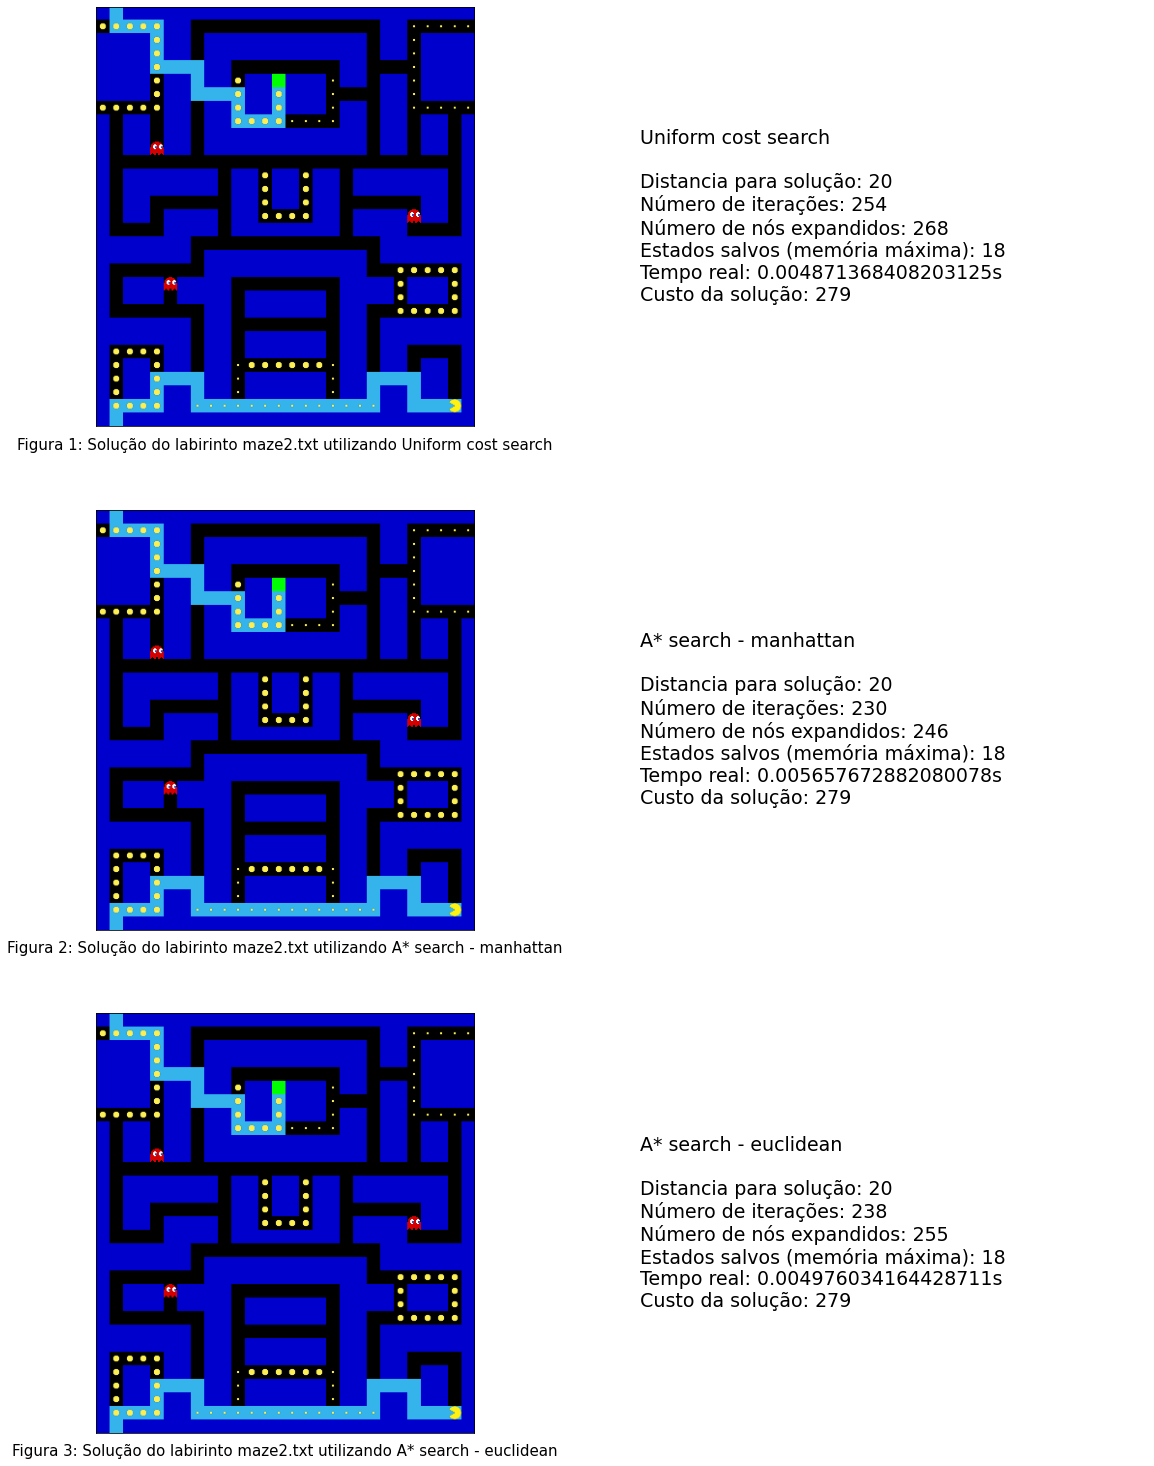

In [43]:
analysis_mazes(['maze2.txt'], 
               [[uniform_cost_search, 'Uniform cost search'],
                [astar_search, 'A* search - manhattan', h_manhattan_distance_trans],
                [astar_search, 'A* search - euclidean', h_euclidean_distance_trans]])

Observa-se que o método **A*** trouxe um custo maior em termos de iterações para encontrar a solução em relação ao *Best First Search*, mas ao contrário deste, este algoritmo **A*** com a **heristíca admissível** é ótimo e encontrou a mesma solução ótima do *Uniform Cost Search* com uma leve redução no número de iterações, tornando-a uma heuristica razoavel para o problema

Tanto a distância de manhattan como a euclideana, são heuristicas admissíveis para o problema pois, o custo mais curto que pode haver entre dois pontos de um mapa é a distancia de manhattan (como não temos movimentos diagonais, e os custos são sempre >= 1), e como euclideana <= manhattan, ambas são otimistas e nunca superstimam o custo da melhor solução. Entretanto, deve-se ter cuidado com os casos transaversaveis:

### simple_pattern_obstacles_small_trans.txt

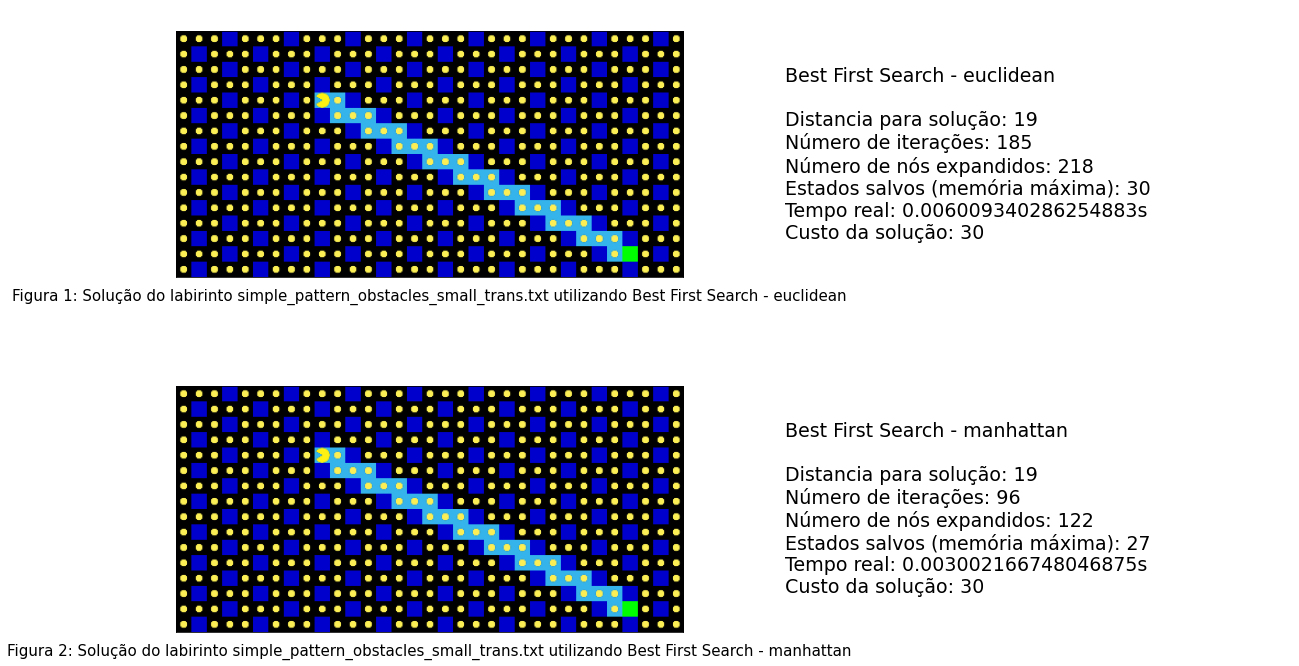

In [61]:
analysis_mazes(['simple_pattern_obstacles_small_trans.txt'], 
               [[astar_search, 'Best First Search - euclidean', h_euclidean_distance],
                [astar_search, 'Best First Search - manhattan', h_manhattan_distance]],
               figsize=(20, 25), mazeargs=[1])

Acima temos exemplo da execução do **A* com heuristícas não admissíveis** pois não levam em conta que o mapa pode ser transversável. Abaixo temos a execução do **A*** com heuristicas corretamente admissíveis:

### simple_pattern_obstacles_small_trans.txt

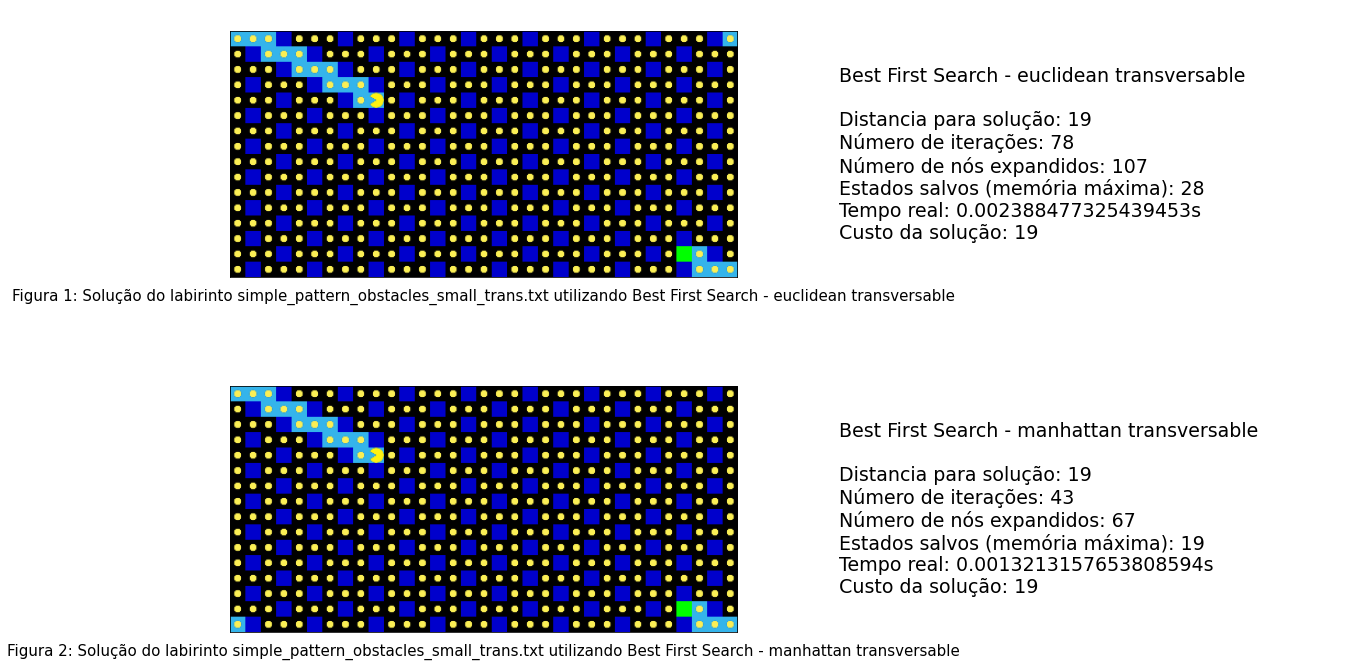

In [62]:
analysis_mazes(['simple_pattern_obstacles_small_trans.txt'], 
               [[astar_search, 'Best First Search - euclidean transversable', h_euclidean_distance_trans],
                [astar_search, 'Best First Search - manhattan transversable', h_manhattan_distance_trans]], 
               figsize=(20, 25), mazeargs=[1])

Neste caso o custo da solução é solução encontrada é o mesmo da solução otimista dada pela heuristíca de Manhattan.

# Hill Climbing

Para facilitar a análise do hill climbing vamos adicionar algumas restrições ao problema: são mapas não transversaveis, e só é possível ter uma posição objetivo.

In [35]:
def hill_climbing(problem, display=False):
    statistics = Statistics()
    statistics.distance = manhattan_distance(problem.initial, problem.maze) 
    current = Node(problem.initial)
    images = []
    
    while True:
        statistics.update_iterations(1)
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmin_random_tie(neighbors, key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) > problem.value(current.state):
            break
        current = neighbor
        ### Plot map
        problem.maze.initial_state = current.state
        images.append(problem.maze.get_map_image())
        ###
        statistics.update_expanded(1)
        
    statistics.finish(current.path_cost)
    
    if display:
        plot_image(*images, titles=[str(i) for i in range(1, len(images))], table_format=(0, 4), figsize=(20, 15*(len(images)/4)))

    if problem.goal_test(current.state):
        return statistics, current
    return statistics, None

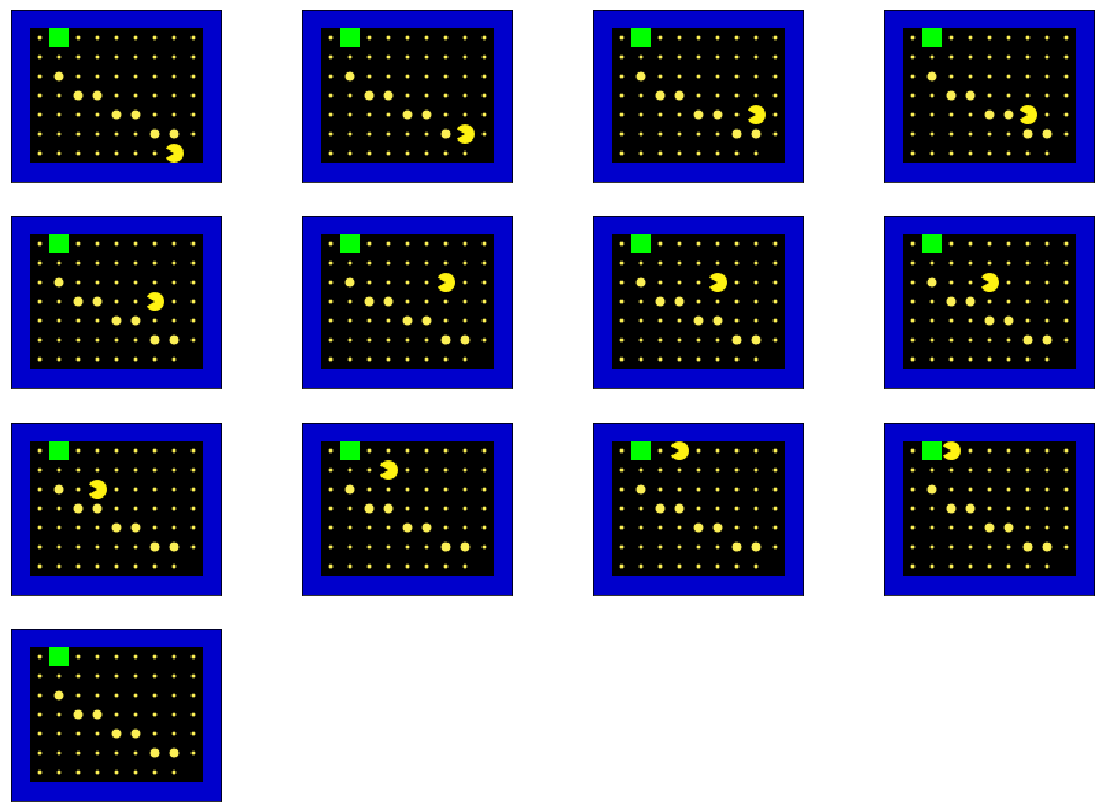

Distancia para solução: 7
Número de iterações: 14
Número de nós expandidos: 14
Estados salvos (memória máxima): 1
Tempo real: 0.009627819061279297s
Custo da solução: 33


In [36]:
maze = Maze("mazes/maze_himclimbing.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

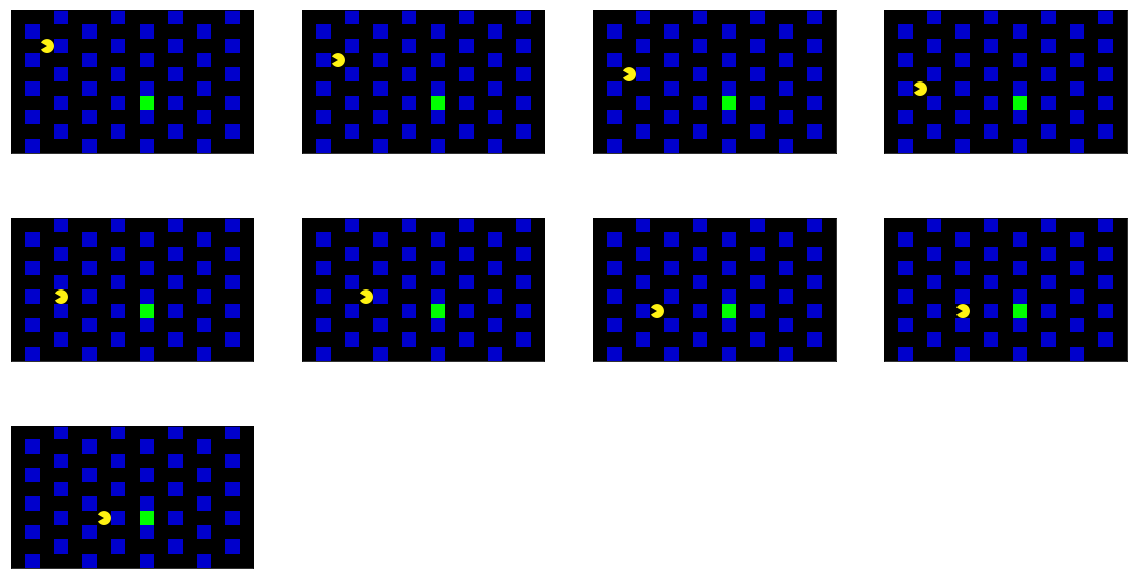

Distancia para solução: 12
Número de iterações: 10
Número de nós expandidos: 10
Estados salvos (memória máxima): 1
Tempo real: 0.00421595573425293s
Custo da solução: 90


In [37]:
maze = Maze("mazes/simple_pattern_obstacles_small_trans2.txt")
problem = MazePacmanProblem(maze)
statistics, node = hill_climbing(problem, display=True)
print(statistics)

# TODO, discussão 

Discussão do Hill Climbing, limitações, vantagens em relação aos outros, desvantagens, como melhorar a implementação

# Análise exaustiva

Análise BFS, DFS, A* ... em gráficos para diferentes posições aleatórias

# A* search

In [16]:
def h_manhatan_distance(problem, n):
    goal_i = problem.goal[0][1]
    goal_j = problem.goal[0][0]
    n_j = n.state[0]
    n_i = n.state[1]
    return abs(n_j - goal_j) + abs(n_i - goal_i)

In [17]:
def h(problem, n):
    '''Essa heuristica conta o numero de obstaculos entre o nó atual e o nó objetivo,
    supõe-se que quanto menos obstaculo, melhor será'''
    goal_i = problem.goal[0][1]
    goal_j = problem.goal[0][0]
    n_j = n.state[0]
    n_i = n.state[1]
    total = 0
    
    # seleciona todas as linhas do labirinto entre as posições do nó e do objetivo
    if goal_i < n_i:
        sub_maze_lines = problem.maze._maze[goal_i:n_i]
    else:
        sub_maze_lines = problem.maze._maze[n_i:goal_i]
    
    # para cada linha verifica entre as colunas do nó e do objetivo, quantos obstaculos existem
    for line in sub_maze_lines:
        if goal_j < n_j:
            sub_maze_columns = line[goal_j:n_j]
        else:
            sub_maze_columns = line[n_j:goal_j]
        total += sub_maze_columns.count(PosType.GHOST.value)
        total += sub_maze_columns.count(PosType.WALL.value)
    return total

In [18]:
def astar_search(problem, h=None, display=False):
    return best_first_graph_search(problem, lambda n: n.path_cost + h(problem, n))

In [19]:
maze = Maze("mazes/maze.txt")
problem = MazePacmanProblem(maze)
node_h1 = astar_search(problem, h_manhatan_distance)
node_h2 = astar_search(problem, h)
maze.print_map()
maze.print_solution(node_h1.solution())
print(len(node_h1.solution()))
print(len(node_h2.solution()))

||||||||||||||||||||||||||||
.....||..............||.....
||||.||.||||||||||||.||.||||
||||.||.||||||||||||.||.||||
||||....||...GG...||....||||
||||.||.||.||||||.||.||.||||
||||.||....||||||....||.||||
.....||.||.||||||.||.||.....
|.||.||.||........||.||.||.|
|.||.||.||||||||||||.||.||.|
|.||.||.||||||||||||.||.||.|
|oooooooooooooooooooooooooo|
|.|||||||.||||||||.|||||||o|
|.|||||||.||||||||.|||||||o|
|.||......||||||||......||o|
|.||.||||.||||||||.||||.||o|
|....||||.||||||||.||||oooo|
|||||||....G.........|||||||
|||||||.||||||||||||.|||||||
|.......|||||||||...G......|
|.|||.||||........||||.|||.|
|.|||.||||.||||||.||||.|||.|
|.......||.||||||.||||.....|
|||||||.||.      ....|||||||
|||||||.||X||||||.||.|||||||
|....||.||.||||||.||.||....|
|.||.||.||........||.||.||.|
|.||....||||||||||||....||.|
|.||.||.||||||||||||.||.||.|
|....||..............||...P|
||||||||||||||||||||||||||||


||||||||||||||||||||||||||||
.....||..............||.....
||||.||.||||||||||||.||.||||
||||.||.||||